In [83]:
import numpy as np

from scipy import signal
from scipy.fft import fft, fftshift

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib import gridspec
from matplotlib.pyplot import pcolormesh

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.visualization import ImageNormalize, SqrtStretch
from astropy.io import fits
from astropy.visualization.mpl_normalize import AsymmetricPercentileInterval
from astropy.visualization import astropy_mpl_style


import datetime

import sunpy.coordinates  # NOQA
import sunpy.map
import sunpy.data.sample
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.visualization.animator import MapSequenceAnimator
from sunpy.map import Map
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.coordinates import Helioprojective, get_body_heliographic_stonyhurst
from sunpy.time import parse_time



import aiapy.data.sample as sample_data
from aiapy.calibrate import register, update_pointing



from PIL import Image

from wavelet_function import wavelet

default_font = 41

In [2]:
from wavelet_function import wavelet

In [4]:
def Fits_to_maps(file):
    """
    file - string to location of wanted files
    """
    # Creating path to images of specified wavelength
    path = os.listdir(file)
    
    # Creating empty array to append processed maps
    maps = []

    # Looping over each image file in the directory and turning them into maps
    for img in path:
        img_path = os.path.join(file, img)
        
        # Loading the FITS file as a SunPy map
        aia_map = sunpy.map.Map(img_path)
        
        # # Check if aia_map is a list (indicating multiple HDUs) and select the first one
        # if isinstance(aia_map, list):
        #     aia_map = aia_map[0]  # Select the primary HDU if only one is needed
        
        maps.append(aia_map)
    
    return maps

In [13]:
def intensity_sum(maps):


    intensity = []
 # summing intenisty of every pixel in the images 
    for map in maps:
        intensity_sum = map.data.sum()
        intensity.append(intensity_sum)
    return intensity

In [9]:
maps_1700 = Fits_to_maps('AIA_1700_prep_rot_done')
maps_1700 = sorted(maps_1700,key = lambda m:m.date)

maps_304 = Fits_to_maps('AIA_304_prep_rot_done')
maps_304 = sorted(maps_304,key = lambda m:m.date)

maps_171 = Fits_to_maps('AIA_171_prep_rot_done')
maps_171 = sorted(maps_171,key = lambda m:m.date)

maps_94 = Fits_to_maps('AIA_94_prep_rot_done')
maps_94 = sorted(maps_94,key = lambda m:m.date)


In [10]:
maps_1700_roi = []
for i in (maps_1700):
    bottom_left = SkyCoord((370)* u.arcsec, -200 * u.arcsec, frame=maps_1700[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -180 * u.arcsec, frame=maps_1700[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_1700_roi.append(submap)

maps_304_roi = []
for i in (maps_304):
    bottom_left = SkyCoord((370)* u.arcsec, -200 * u.arcsec, frame=maps_304[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -180 * u.arcsec, frame=maps_304[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_304_roi.append(submap)

maps_171_roi = []
for i in (maps_171):
    bottom_left = SkyCoord((370)* u.arcsec, -200 * u.arcsec, frame=maps_171[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -180 * u.arcsec, frame=maps_171[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_171_roi.append(submap)

maps_94_roi = []
for i in (maps_94):
    bottom_left = SkyCoord((370)* u.arcsec, -200 * u.arcsec, frame=maps_94[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -180 * u.arcsec, frame=maps_94[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_94_roi.append(submap)

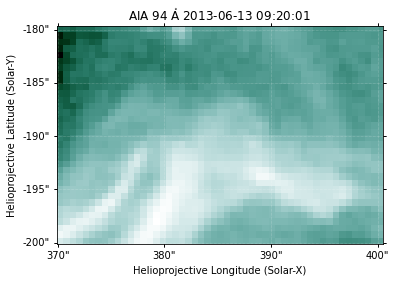

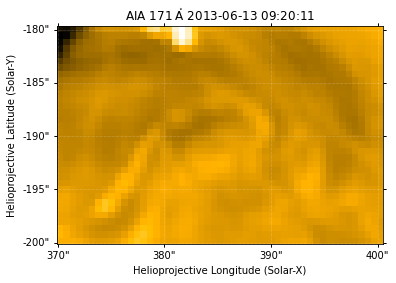

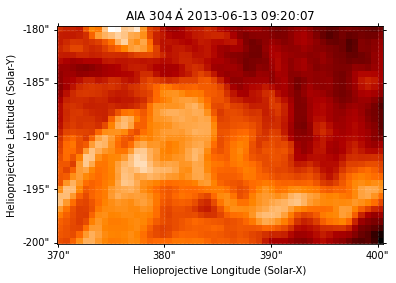

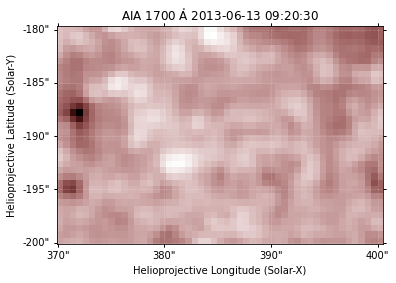

In [11]:
maps_94_roi[0].plot()
plt.show()

maps_171_roi[0].plot()
plt.show()

maps_304_roi[0].plot()
plt.show()

maps_1700_roi[0].plot()
plt.show()

In [14]:
maps_1700_roi_intensity = intensity_sum(maps_1700_roi)
maps_304_roi_intensity = intensity_sum(maps_304_roi)
maps_171_roi_intensity = intensity_sum(maps_171_roi)
maps_94_roi_intensity = intensity_sum(maps_94_roi)

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/1659079609.py:6: UserWarning: shading value ' gouraud' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(fourier_period_94, scale_94,wavelet_transform_94[:,0:31],shading =  ' gouraud')


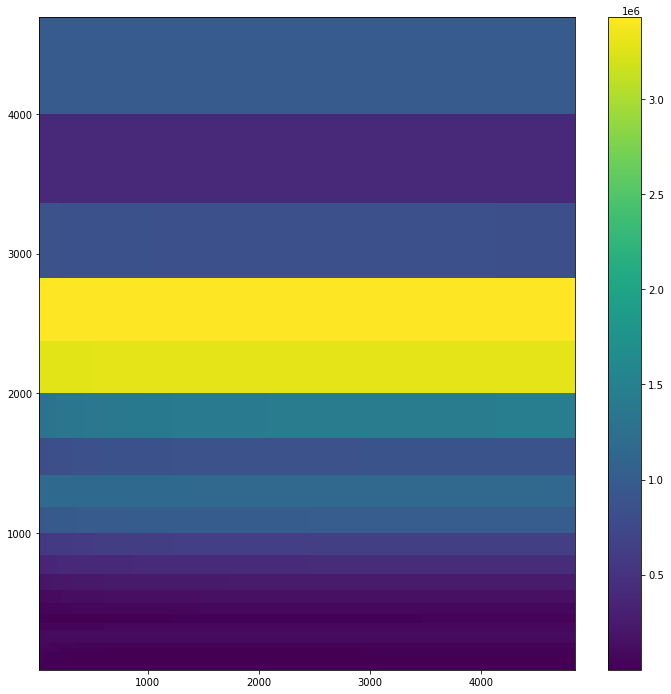

In [28]:
wavelet_transform_94 , fourier_period_94, scale_94, COI_94 = wavelet(maps_94_roi_intensity,12)#s0 = 24,dj = 0.5)

wavelet_transform_94 = np.abs(wavelet_transform_94)

plt.figure(figsize = (12,12))
plt.pcolormesh(fourier_period_94, scale_94,wavelet_transform_94[:,0:31],shading =  ' gouraud')
plt.colorbar()

In [29]:
def windowed_fourier(intensity_array):
   
    intensity_cal = []
    for i in intensity_array:
        intensity = (i-np.mean(intensity_array))/np.std(intensity_array)
        intensity_cal.append(intensity)
    
    intensity_cal = np.ma.masked_less(intensity_cal, 0)

    window = signal.windows.hann(len(intensity_cal))

    plt.figure(figsize = (15,15))
    intensity_window = window*intensity_cal

    fft_result = np.fft.fft(intensity_window)
    fft = (np.abs(fft_result)**2)/np.var(intensity_window)
    freqs = np.fft.fftfreq(len(intensity_window), 12)

    # plt.plot(1/(freqs),(fft))
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.xlabel("Period (s)")
    # plt.ylabel("Magnitude")
    # plt.title("Intensity ")
    # plt.savefig(fname = '171PowerSpectrum.jpeg',format="jpeg", bbox_inches="tight")

    # plt.show()

    return freqs, fft

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/1318568900.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_94,fft_94)


<Figure size 1080x1080 with 0 Axes>

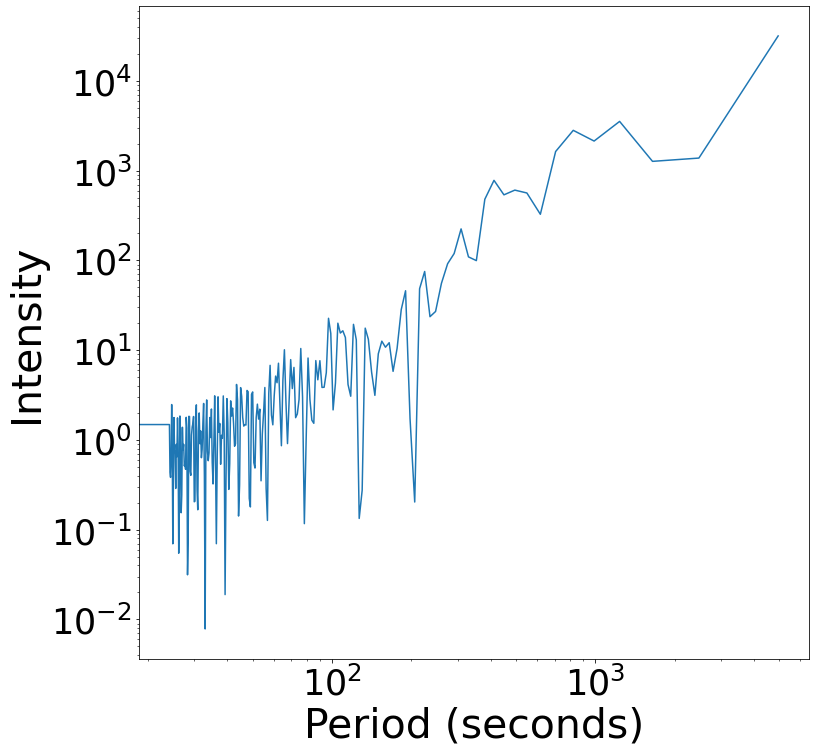

In [85]:
freqs_94, fft_94 = windowed_fourier(maps_94_roi_intensity)

plt.figure(figsize=(12,12))
plt.plot(1/freqs_94,fft_94)
# plt.title('Windowed Fourier Transform of ROI - 94Å',fontsize = default_font)
plt.xlabel('Period (seconds)',fontsize = default_font)
plt.ylabel('Intensity',fontsize = default_font)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 35) 
plt.yticks(fontsize = 35)
plt.savefig(fname = 'WFT_ROI_94_bigger.jpeg',format="jpeg", bbox_inches="tight")
plt.show()

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/2931986901.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_304,fft_304)


<Figure size 1080x1080 with 0 Axes>

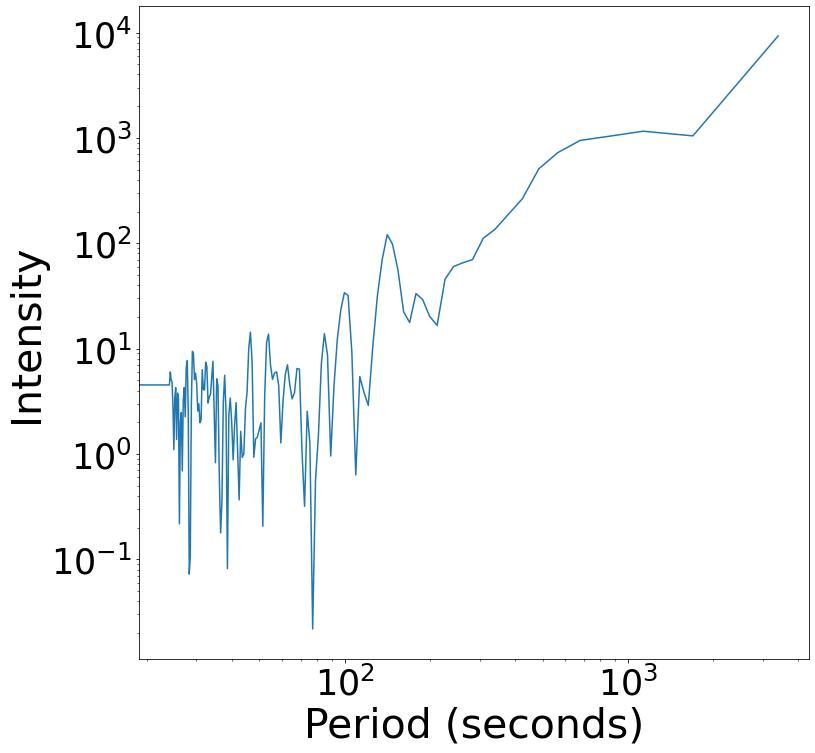

In [92]:
freqs_304, fft_304 = windowed_fourier(maps_304_roi_intensity)

plt.figure(figsize=(12,12))
plt.plot(1/freqs_304,fft_304)
# plt.title('Windowed Fourier Transform of ROI - 304Å',fontsize = 20)
plt.xlabel('Period (seconds)',fontsize = default_font)
plt.ylabel('Intensity',fontsize = default_font)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 35) 
plt.yticks(fontsize = 35)
plt.savefig(fname = 'WFT_ROI_304_bigger.jpeg',format="jpeg", bbox_inches="tight")
plt.show()

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/474613362.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_171,fft_171)


<Figure size 1080x1080 with 0 Axes>

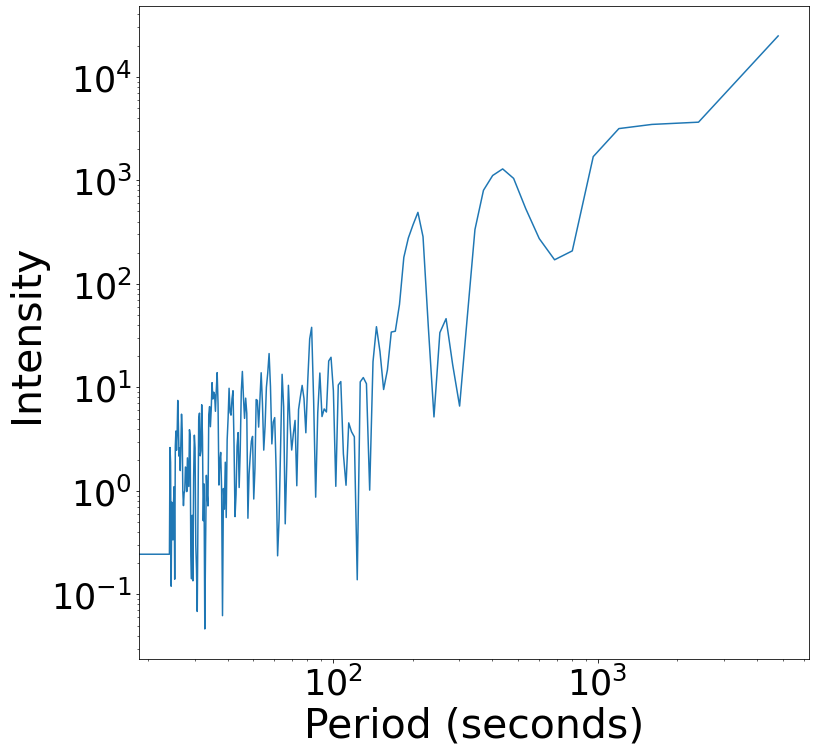

In [91]:
freqs_171, fft_171 = windowed_fourier(maps_171_roi_intensity)

plt.figure(figsize=(12,12))
plt.plot(1/freqs_171,fft_171)
# plt.title('Windowed Fourier Transform of ROI - 171Å',fontsize = 20)
plt.xlabel('Period (seconds)',fontsize = default_font)
plt.ylabel('Intensity',fontsize = default_font)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 35) 
plt.yticks(fontsize = 35)
plt.savefig(fname = 'WFT_ROI_171_bigger.jpeg',format="jpeg", bbox_inches="tight")
plt.show()

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/705028586.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_1700,fft_1700)


<Figure size 1080x1080 with 0 Axes>

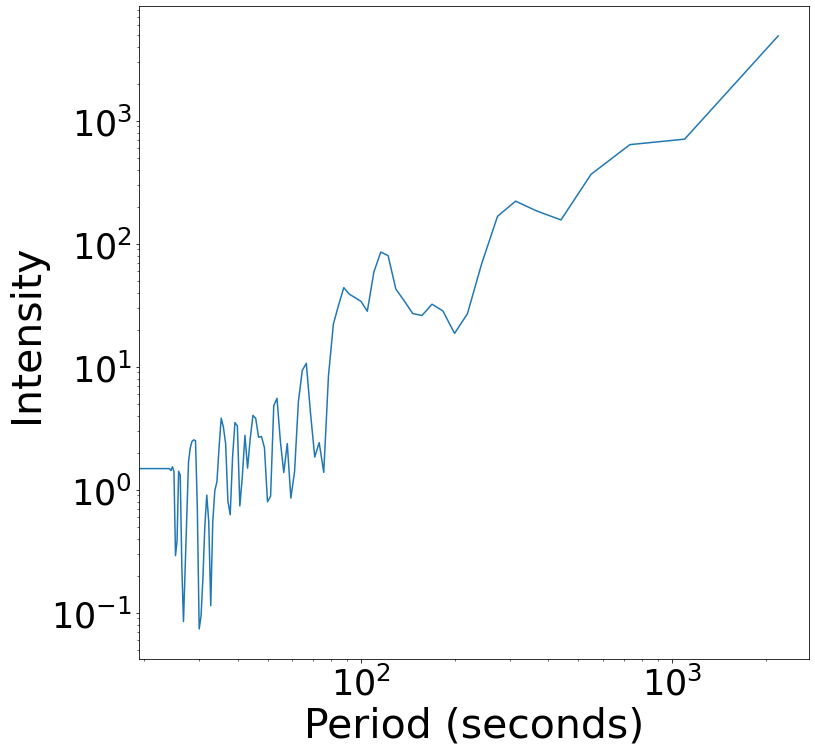

In [90]:
freqs_1700, fft_1700 = windowed_fourier(maps_1700_roi_intensity)

plt.figure(figsize=(12,12))
plt.plot(1/freqs_1700,fft_1700)
# plt.title('Windowed Fourier Transform of ROI - 1700Å',fontsize = 20)
plt.xlabel('Period (seconds)',fontsize = default_font)
plt.ylabel('Intensity',fontsize = default_font)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 35) 
plt.yticks(fontsize = 35)
plt.savefig(fname = 'WFT_ROI_1700_bigger.jpeg',format="jpeg", bbox_inches="tight")
plt.show()

In [48]:
maps_1700_roi_nothing = []
for i in (maps_1700):
    bottom_left = SkyCoord((470)* u.arcsec, -270 * u.arcsec, frame=maps_1700[0].coordinate_frame)
    top_right = SkyCoord((500) * u.arcsec, -250* u.arcsec, frame=maps_1700[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_1700_roi_nothing.append(submap)

maps_304_roi_nothing = []
for i in (maps_304):
    bottom_left = SkyCoord((470)* u.arcsec, -270 * u.arcsec, frame=maps_304[0].coordinate_frame)
    top_right = SkyCoord((500) * u.arcsec, -250* u.arcsec, frame=maps_304[0].coordinate_frame)          
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_304_roi_nothing.append(submap)

maps_171_roi_nothing = []
for i in (maps_171):
    bottom_left = SkyCoord((470)* u.arcsec, -270 * u.arcsec, frame=maps_171[0].coordinate_frame)
    top_right = SkyCoord((500) * u.arcsec, -250* u.arcsec, frame=maps_171[0].coordinate_frame)        
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_171_roi_nothing.append(submap)

maps_94_roi_nothing = []
for i in (maps_94):
    bottom_left = SkyCoord((470)* u.arcsec, -270 * u.arcsec, frame=maps_94[0].coordinate_frame)
    top_right = SkyCoord((500) * u.arcsec, -250* u.arcsec, frame=maps_94[0].coordinate_frame)        
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_94_roi_nothing.append(submap)

In [50]:
maps_1700_nothing_intensity = intensity_sum(maps_1700_roi_nothing)
maps_304_nothing_intensity = intensity_sum(maps_304_roi_nothing)
maps_171_nothing_intensity = intensity_sum(maps_171_roi_nothing)
maps_94_nothing_intensity = intensity_sum(maps_94_roi_nothing)

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/2091870172.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_94,fft_94)


<Figure size 1080x1080 with 0 Axes>

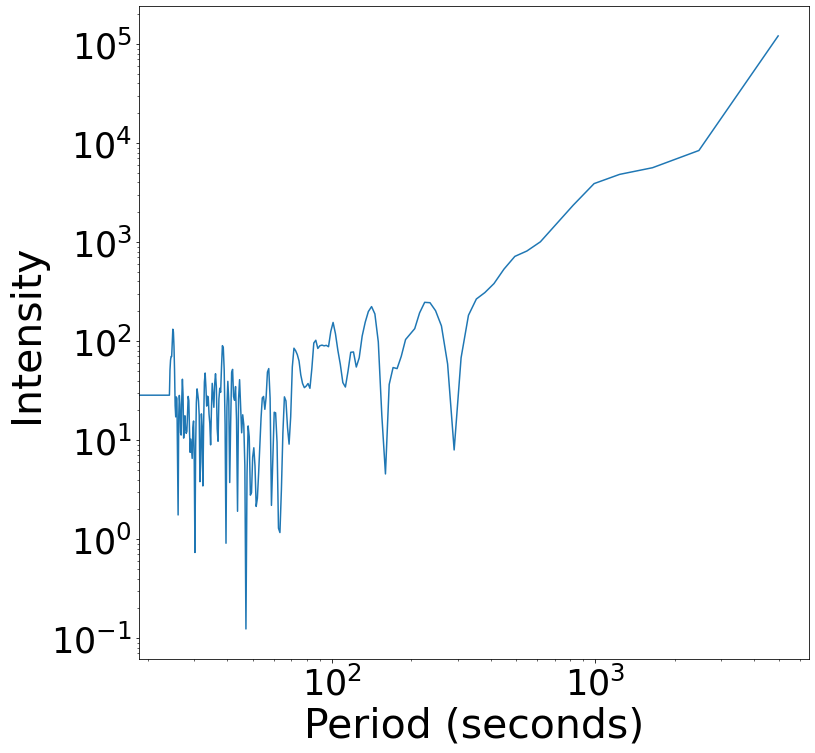

In [98]:
freqs_94, fft_94 = windowed_fourier(maps_94_nothing_intensity)

plt.figure(figsize=(12,12))
plt.plot(1/freqs_94,fft_94)
# plt.title('Windowed Fourier Transform of Region of Nothing - 94Å',fontsize = 20)
plt.xlabel('Period (seconds)',fontsize = default_font)
plt.ylabel('Intensity',fontsize = default_font)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 35) 
plt.yticks(fontsize = 35)
plt.savefig(fname = 'WFT_nothing_94_bigger.jpeg',format="jpeg", bbox_inches="tight")
plt.show()

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/4131280426.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_171,fft_171)


<Figure size 1080x1080 with 0 Axes>

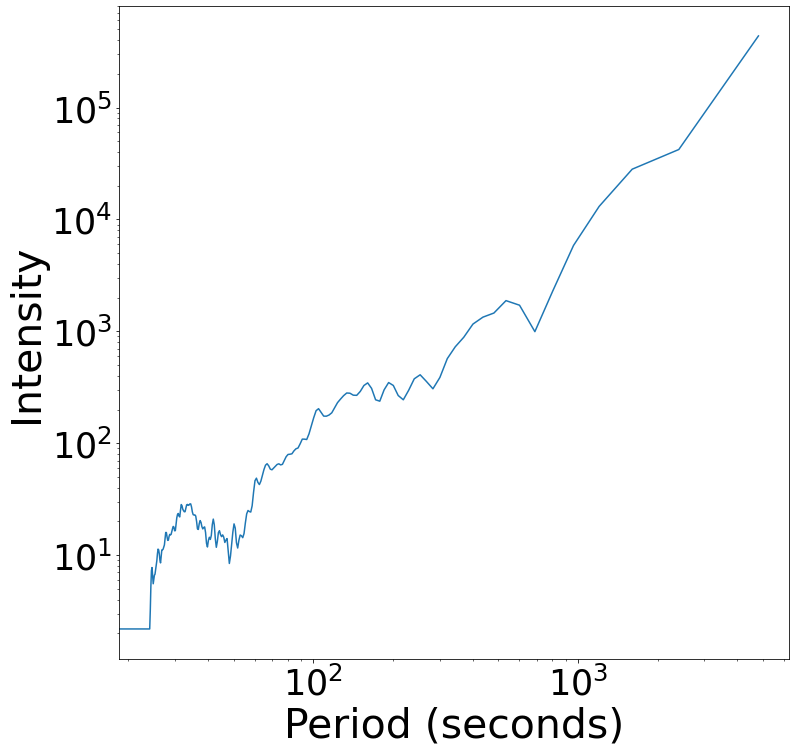

In [97]:
freqs_171, fft_171 = windowed_fourier(maps_171_nothing_intensity)

plt.figure(figsize=(12,12))
plt.plot(1/freqs_171,fft_171)
# plt.title('Windowed Fourier Transform of Region of Nothing - 171Å',fontsize = 20)
plt.xlabel('Period (seconds)',fontsize = default_font)
plt.ylabel('Intensity',fontsize = default_font)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 35) 
plt.yticks(fontsize = 35)
plt.savefig(fname = 'WFT_nothing_171_bigger.jpeg',format="jpeg", bbox_inches="tight")
plt.show()

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/13800923.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_304,fft_304)


<Figure size 1080x1080 with 0 Axes>

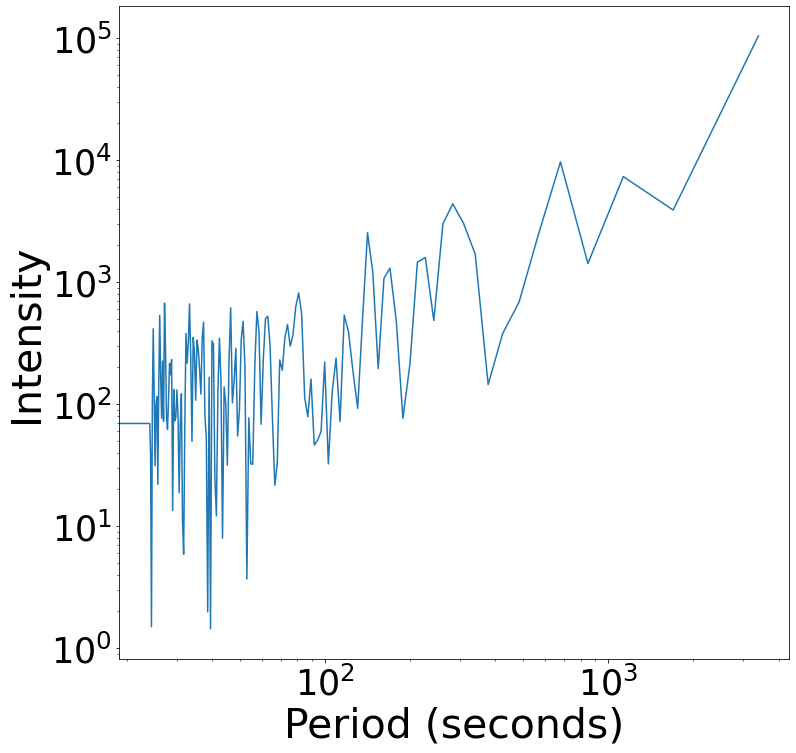

In [96]:
freqs_304, fft_304 = windowed_fourier(maps_304_nothing_intensity)

plt.figure(figsize=(12,12))
plt.plot(1/freqs_304,fft_304)
# plt.title('Windowed Fourier Transform of Region of Nothing - 304Å',fontsize = 20)
plt.xlabel('Period (seconds)',fontsize = default_font)
plt.ylabel('Intensity',fontsize = default_font)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 35) 
plt.yticks(fontsize = 35)

plt.savefig(fname = 'WFT_nothing_304_bigger.jpeg',format="jpeg", bbox_inches="tight")
plt.show()

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_17902/3667969906.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_1700,fft_1700)


<Figure size 1080x1080 with 0 Axes>

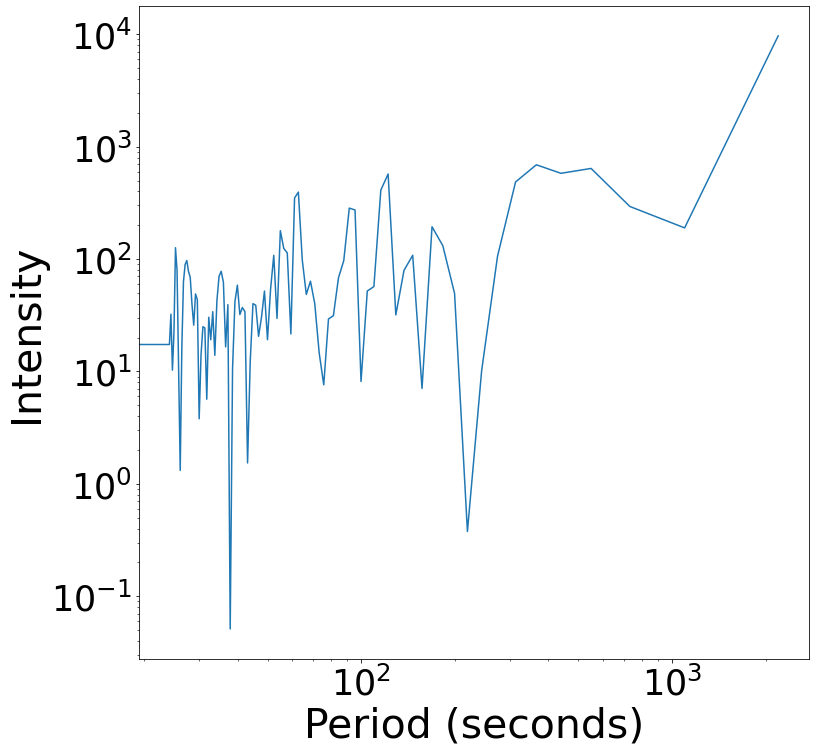

In [95]:
freqs_1700, fft_1700 = windowed_fourier(maps_1700_nothing_intensity)

plt.figure(figsize=(12,12))
plt.plot(1/freqs_1700,fft_1700)
# plt.title('Windowed Fourier Transform of Region of Nothing - 1700Å',fontsize = 20)
plt.xlabel('Period (seconds)',fontsize = default_font)
plt.ylabel('Intensity',fontsize = default_font)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 35) 
plt.yticks(fontsize = 35)
plt.savefig(fname = 'WFT_nothing_1700_bigger.jpeg',format="jpeg", bbox_inches="tight")
plt.show()